**Sections**
<a id='sections'></a>

- [**4B Features Correlation Test**](#feature-correlation-test)
    - [4B.1. Feature Correlation](#feature-correlation)
    - [4B.2. Features & Crash/NoCrash](#features-&-crash-nocrash)
        - [4B.2.1 Rural Area](#binary-rural-area)
            - [4B.2.1.1 Imbalanced Dataset](#binary-rural-imbalanced-dataset)
            - [4B.2.1.2 Balanced Dataset](#binary-rural-balanced-dataset)
        - [4B.2.2 Urban Area](#binary-urban-area)
            - [4B.2.2.1 Imbalanced Dataset](#binary-urban-imbalanced-dataset)
            - [4B.2.2.2 Balanced Dataset](#binary-urban-balanced-dataset)
    - [4B.3. Features & Crash Counts](#features-&-crash-counts)
        - [4B.3.1 Rural Area](#multiclass-rural-area)
        - [4B.3.2 Urban Area](#multiclass-urban-area)

In [1]:
from scipy import stats
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

In [2]:
# import modules
import sys; sys.path.insert(0, '..')
import src.multiclass_models
import importlib
importlib.reload (src.multiclass_models)
from src.multiclass_models import *

Using TensorFlow backend.
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xl43843\Anaconda3\en

In [3]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

In [4]:
def cal_df_binned(test_df,test_feature,test_label,bins_range):
    df_binned = pd.DataFrame(index=bins_range[1:])
    df_binned['index'] = bins_range[1:]
    df_binned['RoadCount']=stats.binned_statistic(test_df[test_feature], test_df[test_feature], 'count', bins=np.array(bins_range)+0.1)[0]
    df_binned['RoadPct'] = df_binned['RoadCount'].values/sum(df_binned['RoadCount'].values)
    df_binned['TotalCrashCount']=stats.binned_statistic(test_df[test_feature], test_label, 'sum', bins=np.array(bins_range)+0.1)[0]
    df_binned['CrashCountPct']=df_binned['TotalCrashCount'].values/sum(df_binned['TotalCrashCount'].values)
    df_binned['CrashRate']=df_binned['TotalCrashCount'].values/df_binned['RoadCount'].values
    df_binned['CrashCountStd']=stats.binned_statistic(test_df[test_feature], test_label, 'std', bins=np.array(bins_range)+0.1)[0]
    return df_binned

In [5]:
def plt_binnedstats(df_binned,bins_range,test_df,test_label,test_feature):
    fig, axs = plt.subplots(1, 3,figsize=(14, 3),sharey=False)
    plt.xticks(rotation=90)
    axs[0].scatter(x=test_df[test_feature],y=test_label,alpha=0.2)
    df_binned.plot(ax=axs[1],x="index", y=["RoadPct", "CrashCountPct"], kind="bar")
#     axs[1].scatter(bins_range[1:], df_binned['RoadPct']*100, color = 'grey')
#     axs[1].scatter(bins_range[1:], df_binned['CrashCountPct']*100, color = 'g')
    axs[2].scatter(df_binned['index'], df_binned['CrashRate']*100, color = 'r')
    axs[0].set_title('Crash Records')
    axs[1].set_title('Road Percentage VS Crash percentage')
    axs[2].set_title('Average number of crashes per segment')
    axs[1].set_xlabel(test_feature)
    axs[2].set_xlabel(test_feature)
    axs[1].set_ylabel('Percentage (100%)')
    axs[0].set_xlabel(test_feature)
    axs[0].set_ylabel('Number of crashes')
    plt.show() 

In [6]:
def catstats(test_df,test_label,test_feature):
    
    group_df = pd.DataFrame()
    group_df[test_feature] = test_df[test_feature]
    group_df['y'] = test_label
    group_df = group_df.sort_values(by=test_feature)

    cat_stats = pd.DataFrame(index=group_df[test_feature].value_counts().index)
    cat_stats['index'] = group_df[test_feature].value_counts().index
    cat_stats['RoadCount'] = group_df[test_feature].value_counts()
    cat_stats['RoadCountPct'] = cat_stats['RoadCount']/sum(cat_stats['RoadCount'])
    cat_stats['TotalCrash'] = group_df.groupby(test_feature).sum()
    cat_stats['CrashCountPct'] = cat_stats['TotalCrash']/sum(cat_stats['TotalCrash'])
    cat_stats['CrashRate'] = group_df.groupby(test_feature).mean()
    cat_stats = cat_stats.sort_values(by='index')
    
    return cat_stats

In [7]:
def plt_catstats(test_df,test_label,test_feature,cat_stats):
    
    full_testdf = test_df.copy()
    full_testdf['y'] = test_label
    full_testdf = full_testdf.sort_values(by=test_feature)
    
    fig, axs = plt.subplots(1,3,figsize=(14, 3),sharey=False)
    plt.xticks(rotation=90)
    
    axs[0].scatter(full_testdf[test_feature],full_testdf['y'],alpha=0.2)
    cat_stats.plot(ax=axs[1],x="index", y=["RoadCountPct", "CrashCountPct"], kind="bar")
    axs[2].scatter(cat_stats['index'],cat_stats['CrashRate'], color = 'r')
    
    axs[0].tick_params(axis="x", labelrotation=90) 
    axs[0].set_xlabel(test_feature)
    axs[0].set_title('Crash Records')
    axs[1].set_xlabel(test_feature)
    axs[1].set_ylabel('Percentage (100%)')
    axs[1].set_title('Road Percentage VS Crash percentage')
    axs[2].set_xlabel(test_feature)
    axs[2].set_title('Average number of crashes per segment')
    
    plt.show() 

In [8]:
def cramers_V(df, bilabel, features):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    cramers_V_result = pd.DataFrame(index=features)
    for f in features:
        confusion_matrix =  pd.crosstab(df[f].values,bilabel)
        chitest_result = chi2_contingency(confusion_matrix)
        chi = chitest_result[0]
        p = chitest_result[1]
        n = df.shape[0]
        phi2 = chi/n
        r,k = confusion_matrix.shape
        if min((k-1), (r-1))>0:
            phic = np.sqrt(phi2 / min((k-1), (r-1)))
            cramers_V_result.loc[f,'phic']=phic
            cramers_V_result.loc[f,'p']=p
        
    return cramers_V_result

In [9]:
Norminal_multi = ['bicycle_path_category','bicycle_buffer_type','bicycle_path_type','bicycle_approach_alignment',
            'crossing_functional_classification','functional_classification','intersection_control_type','lane_configuration','road_sign_type','sidewalk_buffer_type','overall_landuse','I_SHD1_TYP','I_SHD2_TYP',
           'MED_TYP','SURF_TYP','O_SHD1_TYP','O_SHD2_TYP','PRK_LT','PRK_RT','JUR_TYPE','MUNI_NAME','NHS','TRK_RT','ACC_CNTL']
Norminal_binary = ['one_way','marked_center_line','railroad_crossing_type','OP_1_2_WAY']
Ordinal = ['PC']

Discrete = ['crossing_speed','max_lanes_crossed','posted_speed','total_lanes','LNS']
Continuous =['bicycle_facility_width','bicycle_buffer_width',
             'sidewalk_buffer_width','sidewalk_width','sidewalk_condition_score',
             'I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH',
             'LN_WTH','SURF_WTH','parking_lane_width','right_turn_length','st_length','curve_ratio',
             'bus_trips_total','crossing_aadt','volume_capacity','AADT', 'HCV', 'Pop_den']

Noneedtotest = ['in_urbanized_area','MPO']
RuralNoNeed_Norminal_multi = ['road_sign_type','marked_center_line','lane_configuration','bicycle_approach_alignment']
Rural_Norminal_multi = list(set(Norminal_multi) - set(RuralNoNeed_Norminal_multi))

# Feature Correlation
[[back to top](#sections)]
<a id='feature-correlation'></a>

In [10]:
with open(base_file_dir+'data/interim/roadway/preprocessing/df_final.pkl', 'rb') as f:
    df = pickle.load(f)

In [11]:
# Delete samples that have NaN values
## 'geometry' is not included
cleandf = df[['st_length', 'curve_ratio', 'one_way',
       'bicycle_facility_width', 'bicycle_path_category',
       'bicycle_buffer_width', 'bicycle_buffer_type', 'bicycle_path_type',
       'bicycle_approach_alignment', 'bus_trips_total', 'crossing_aadt',
       'crossing_functional_classification', 'crossing_speed',
       'functional_classification', 'intersection_control_type',
       'lane_configuration', 'max_lanes_crossed', 'parking_lane_width',
       'marked_center_line', 'posted_speed', 'railroad_crossing_type',
       'right_turn_length', 'road_sign_type', 'sidewalk_buffer_width',
       'sidewalk_condition_score', 'sidewalk_width', 'sidewalk_buffer_type',
       'total_lanes', 'in_urbanized_area', 'volume_capacity',
       'overall_landuse', 'ACC_CNTL', 'I_SHD1_TYP', 'I_SHD1_WTH', 'I_SHD2_TYP',
       'I_SHD2_WTH', 'LN_WTH', 'LNS', 'MED_TYP', 'MED_WTH', 'SURF_TYP',
       'SURF_WTH', 'O_SHD1_TYP', 'O_SHD1_WTH', 'O_SHD2_TYP', 'O_SHD2_WTH',
       'OP_1_2_WAY', 'PRK_LT', 'PRK_RT', 'JUR_TYPE', 'MPO', 'MUNI_NAME', 'NHS',
       'TRK_RT', 'AADT', 'HCV', 'Pop_den', 'PC', 'Year','Crashes']].dropna()

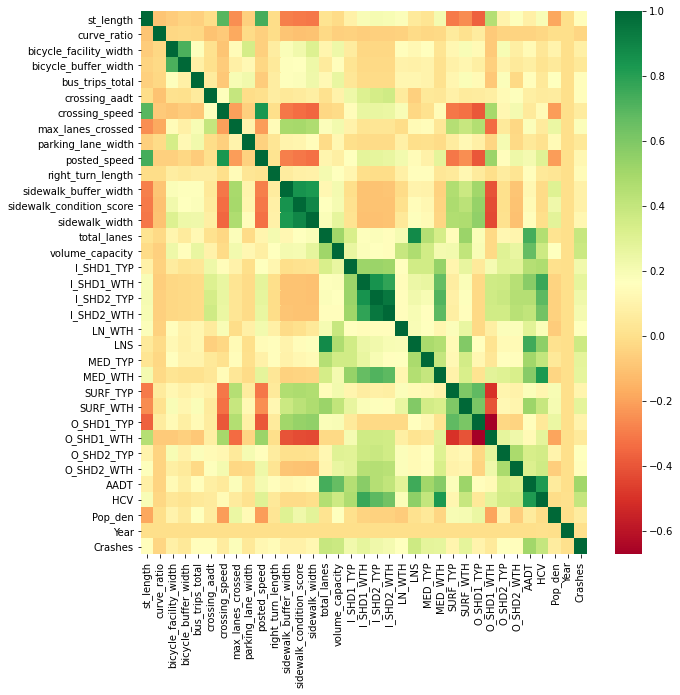

In [12]:
# Compute pairwise correlation of columns, excluding NA/null values.
heatmap = cleandf.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cleandf.corr(),annot=False,cmap ='RdYlGn')

# Features & Crash/No Crash
[[back to top](#sections)]
<a id='binary-rural-area'></a>

- **Crash/NoCrash (0,1)**, Categorical variable
    - **Association with Categorical variable**
    X: Categorical features, Y: Crash/No Crash 
        - Use Cramer's V test
    - **Association with Numerical variable**
    X: Crash/No Crash, Y: Numerical features
        - Use point-biserial correlation test to measure the relationship
            - 0 implies no correlation. Correlations of -1 or +1 imply a determinative relationship

## Rural Area
[[back to top](#sections)]
<a id='binary-rural-area'></a>

In [13]:
with open(base_file_dir+'data/processed/df_rural_train_2014_2017.pkl', 'rb') as f:
    df_rural_train = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_train_label_2014_2017.pkl', 'rb') as f:
    df_rural_train_label = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_2018.pkl', 'rb') as f:
    df_rural_test = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_label_2018.pkl', 'rb') as f:
    df_rural_test_label = pickle.load(f)
    
print(df_rural_train.shape)
print(df_rural_train_label.shape)
print(df_rural_test.shape)
print(df_rural_test_label.shape)

(22736, 62)
(22736,)
(5684, 62)
(5684,)


In [14]:
df_rural_test=func_PC_numeric(df_rural_test)
df_rural_train=func_PC_numeric(df_rural_train)

remove_list=['segment_id','overlap','geometry','Year']

df_rural_train_sub=func_remove_var(df_rural_train, remove_list)
df_rural_train_bi_label=df_rural_train_label.mask(df_rural_train_label >= 2, 1)
df_rural_test_sub=func_remove_var(df_rural_test, remove_list)
df_rural_test_bi_label=df_rural_test_label.mask(df_rural_test_label >= 2, 1)

### Imbalanced Dataset
[[back to top](#sections)]
<a id='binary-rural-imbalanced-dataset'></a>

In [15]:
df = df_rural_train_sub
bilabel = df_rural_train_bi_label

In [16]:
# Association test to measure the relative of an association between Categorical features & Crash/NoCrash

# >.5                   high association
# .3 to .5             moderate association
# .1 to .3             low association
# 0 to .1              little if any association

df = df_rural_train_sub
label = df_rural_train_bi_label

features = Norminal_multi+Norminal_binary+Ordinal
cramers_V_result = cramers_V(df, label, features)
cramers_V_result.sort_values(by=['phic','p'],ascending=False)

phic              p
functional_classification           0.368908   0.000000e+00
TRK_RT                              0.362012   0.000000e+00
O_SHD1_TYP                          0.333513   0.000000e+00
JUR_TYPE                            0.331705   0.000000e+00
SURF_TYP                            0.328093   0.000000e+00
O_SHD2_TYP                          0.318454   0.000000e+00
NHS                                 0.299263   0.000000e+00
MED_TYP                             0.295289   0.000000e+00
I_SHD2_TYP                          0.279017   0.000000e+00
I_SHD1_TYP                          0.276284   0.000000e+00
crossing_functional_classification  0.272003   0.000000e+00
ACC_CNTL                            0.270792   0.000000e+00
PC                                  0.225051  9.243432e-247
one_way                             0.219792  7.556893e-241
MUNI_NAME                           0.111339   1.033896e-48
PRK_LT                              0.094871   4.201565e-44
PRK_RT                              0.093755   4.548435e-43
overall_landuse                     0.092173   8.960766e-37
OP_1_2_WAY                          0.045881   4.577525e-12
bicycle_buffer_type                 0.037694   5.172876e-06
bicycle_path_category               0.023030   2.407316e-03
bicycle_path_type                   0.023030   2.407316e-03
railroad_crossing_type              0.015265   2.134738e-02
sidewalk_buffer_type                0.014244   3.293382e-01
intersection_control_type           0.007564   2.540691e-01
bicycle_approach_alignment               NaN            NaN
lane_configuration                       NaN            NaN
road_sign_type                           NaN            NaN
marked_center_line                       NaN            NaN

In [17]:
# Association of Numerical variable
df = df_rural_train_sub
label = df_rural_train_bi_label
testvar = ['crossing_speed','max_lanes_crossed','posted_speed','bicycle_facility_width','bicycle_buffer_width','sidewalk_buffer_width','sidewalk_width',
'sidewalk_condition_score','I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH','LN_WTH','SURF_WTH','curve_ratio','crossing_aadt','volume_capacity','AADT','HCV','Pop_den',
#            'st_length',
          ]

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.pointbiserialr(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(label,featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
volume_capacity           0.300575       0.0
I_SHD1_WTH                0.273392       0.0
I_SHD2_WTH                0.247596       0.0
O_SHD2_WTH                0.233617       0.0
SURF_WTH                  0.186651       0.0
posted_speed              0.149663       0.0
crossing_speed            0.140357       0.0
HCV                       0.045986       0.0
max_lanes_crossed         0.039795       0.0
crossing_aadt             0.038346       0.0
bicycle_facility_width    0.020905   0.00162
sidewalk_buffer_width     0.020506  0.001987
sidewalk_width             0.01696  0.010547
bicycle_buffer_width      0.011637  0.079332
sidewalk_condition_score  0.008824  0.183366
curve_ratio              -0.004126  0.533871
Pop_den                  -0.019459  0.003343
LN_WTH                   -0.038478       0.0
O_SHD1_WTH               -0.043953       0.0
AADT                     -0.123422       0.0

In [18]:
# Association of Numerical variable weighted by st_length
df = df_rural_train_sub
label = df_rural_train_bi_label
testvar = ['crossing_speed','max_lanes_crossed','posted_speed','bicycle_facility_width','bicycle_buffer_width','sidewalk_buffer_width','sidewalk_width',
'sidewalk_condition_score','I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH','LN_WTH','SURF_WTH','curve_ratio','crossing_aadt','volume_capacity','AADT','HCV','Pop_den',
#            'st_length',
          ]

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    weighted_featurevalue = featurevalue*df['st_length'].values
    teststats.loc[feature,'stats'] = stats.pointbiserialr(label,weighted_featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(label,weighted_featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
volume_capacity           0.325008       0.0
SURF_WTH                  0.288844       0.0
O_SHD2_WTH                 0.28236       0.0
I_SHD1_WTH                0.258172       0.0
I_SHD2_WTH                0.212036       0.0
HCV                       0.207299       0.0
posted_speed              0.199348       0.0
crossing_speed            0.196929       0.0
curve_ratio               0.162101       0.0
Pop_den                   0.140743       0.0
AADT                      0.114704       0.0
crossing_aadt             0.098892       0.0
O_SHD1_WTH                0.086672       0.0
sidewalk_width            0.046577       0.0
max_lanes_crossed         0.046042       0.0
sidewalk_buffer_width     0.042414       0.0
sidewalk_condition_score  0.037435       0.0
bicycle_facility_width    0.035098       0.0
bicycle_buffer_width      0.025839  0.000098
LN_WTH                    0.006648  0.316182

### Balanced Dataset
[[back to top](#sections)]
<a id='binary-rural-balanced-dataset'></a>

In [19]:
df_x = df_rural_train_sub
df_y = df_rural_train_bi_label
train_full = df_x.copy()
train_full['y'] = df_y
print(train_full['y'].value_counts())

neg_sample = train_full[train_full['y']==0].sample(n=train_full['y'].value_counts()[1])
pos_sample = train_full[train_full['y']==1]
sample = pd.concat([neg_sample,pos_sample])
df_sample = sample.iloc[:,:-1]
bilabel_sample = sample['y'].values
print(sample['y'].value_counts())

0.0    21045
1.0     1691
Name: y, dtype: int64
0.0    1691
1.0    1691
Name: y, dtype: int64


In [20]:
# Association test to measure the relative of an association between Categorical features & Crash/NoCrash

# >.5                   high association
# .3 to .5             moderate association
# .1 to .3             low association
# 0 to .1              little if any association
df = df_sample
label = bilabel_sample

features = Norminal_multi+Norminal_binary+Ordinal
cramers_V_result = cramers_V(df, label, features)
cramers_V_result.sort_values(by=['phic','p'],ascending=False)

phic              p
functional_classification           0.462466  4.445381e-154
JUR_TYPE                            0.444201  6.950026e-141
SURF_TYP                            0.419068  5.439410e-113
O_SHD1_TYP                          0.412754  2.707425e-118
PC                                  0.359232   4.134071e-92
TRK_RT                              0.353296   2.161786e-92
O_SHD2_TYP                          0.336488   1.419455e-80
NHS                                 0.310042   1.122669e-72
crossing_functional_classification  0.287464   2.583970e-58
ACC_CNTL                            0.276518   7.028046e-57
I_SHD1_TYP                          0.269001   9.041113e-53
I_SHD2_TYP                          0.262349   2.845571e-51
MED_TYP                             0.259398   4.409838e-48
MUNI_NAME                           0.242743   4.729491e-32
one_way                             0.215194   6.214201e-36
overall_landuse                     0.182728   3.729511e-20
PRK_RT                              0.140876   1.765842e-14
PRK_LT                              0.140200   2.423068e-14
OP_1_2_WAY                          0.077531   6.519879e-06
bicycle_buffer_type                 0.056807   5.311618e-02
bicycle_path_category               0.046524   2.572698e-02
bicycle_path_type                   0.046524   2.572698e-02
sidewalk_buffer_type                0.037297   3.189716e-01
railroad_crossing_type              0.026275   1.265054e-01
bicycle_approach_alignment               NaN            NaN
intersection_control_type                NaN            NaN
lane_configuration                       NaN            NaN
road_sign_type                           NaN            NaN
marked_center_line                       NaN            NaN

In [21]:
# Association of Numerical variable

# ['parking_lane_width','right_turn_length','bus_trips_total'] are all 0 in Rural dataset
# ['total_lanes','LNS'] is not convincing for association test in the imbalanced case

df = df_sample
label = bilabel_sample
testvar = ['crossing_speed','max_lanes_crossed','posted_speed',
                               'bicycle_facility_width','bicycle_buffer_width','sidewalk_buffer_width','sidewalk_width',
                              'sidewalk_condition_score','I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH','LN_WTH',
                              'SURF_WTH','st_length','curve_ratio','crossing_aadt','volume_capacity','AADT','HCV','Pop_den']

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.pointbiserialr(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(label,featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
volume_capacity           0.400051       0.0
posted_speed              0.284261       0.0
O_SHD2_WTH                0.282795       0.0
SURF_WTH                  0.277201       0.0
crossing_speed            0.270138       0.0
I_SHD1_WTH                0.256248       0.0
I_SHD2_WTH                0.239892       0.0
crossing_aadt             0.095779       0.0
HCV                       0.088173       0.0
st_length                 0.066637  0.000105
max_lanes_crossed         0.040984  0.017147
bicycle_facility_width    0.032874  0.055927
sidewalk_buffer_width     0.029927  0.081835
sidewalk_width            0.019085  0.267179
bicycle_buffer_width      0.018951  0.270565
sidewalk_condition_score  0.009131  0.595546
curve_ratio              -0.019878  0.247798
Pop_den                   -0.03595  0.036565
O_SHD1_WTH               -0.054194  0.001617
LN_WTH                   -0.073798  0.000017
AADT                     -0.211098       0.0

In [22]:
# Association of Numerical variable weighted by st_length
# ['parking_lane_width','right_turn_length','bus_trips_total'] are all 0 in Rural dataset
# ['total_lanes','LNS'] is not convincing for association test in the imbalanced case

df = df_sample
label = bilabel_sample
testvar = ['crossing_speed','max_lanes_crossed','posted_speed','bicycle_facility_width','bicycle_buffer_width','sidewalk_buffer_width','sidewalk_width',
'sidewalk_condition_score','I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH','LN_WTH','SURF_WTH','curve_ratio','crossing_aadt','volume_capacity','AADT','HCV','Pop_den',
#            'st_length',
          ]

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    weighted_featurevalue = featurevalue*df['st_length'].values
    teststats.loc[feature,'stats'] = stats.pointbiserialr(label,weighted_featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(label,weighted_featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
posted_speed              0.280248       0.0
crossing_speed            0.277917       0.0
volume_capacity           0.274483       0.0
HCV                       0.256103       0.0
O_SHD2_WTH                0.246541       0.0
SURF_WTH                  0.244944       0.0
curve_ratio                0.22176       0.0
Pop_den                   0.214584       0.0
AADT                       0.19741       0.0
I_SHD1_WTH                0.196069       0.0
crossing_aadt             0.190826       0.0
O_SHD1_WTH                0.187687       0.0
I_SHD2_WTH                0.159763       0.0
sidewalk_width            0.062765   0.00026
sidewalk_buffer_width     0.055539  0.001233
sidewalk_condition_score  0.050625  0.003231
bicycle_facility_width    0.045978  0.007489
max_lanes_crossed         0.042106  0.014332
bicycle_buffer_width      0.033959  0.048297
LN_WTH                    0.031637  0.065827

## Urban Area
[[back to top](#sections)]
<a id='binary-urban-area'></a>

In [23]:
with open(base_file_dir+'data/processed/df_urban_train_2014_2017.pkl', 'rb') as f:
    df_urban_train = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_train_label_2014_2017.pkl', 'rb') as f:
    df_urban_train_label = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_2018.pkl', 'rb') as f:
    df_urban_test = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_label_2018.pkl', 'rb') as f:
    df_urban_test_label = pickle.load(f)
    
print(df_urban_train.shape)
print(df_urban_train_label.shape)
print(df_urban_test.shape)
print(df_urban_test_label.shape)

(25560, 62)
(25560,)
(6390, 62)
(6390,)


In [24]:
remove_list=['segment_id','overlap','geometry','Year']
df_urban_train_sub=func_remove_var(df_urban_train, remove_list)
df_urban_test_sub=func_remove_var(df_urban_test, remove_list)

# Convert full training & testing data to binary class categories
df_urban_train_bi_label = df_urban_train_label.mask(df_urban_train_label >=2, 1)
df_urban_test_bi_label=df_urban_test_label.mask(df_urban_test_label >= 2, 1)

### Imbalanced Dataset
[[back to top](#sections)]
<a id='binary-urban-imbalanced-dataset'></a>

In [25]:
df = df_urban_train_sub
label = df_urban_train_bi_label

In [26]:
# Association test to measure the relative of an association between Categorical features & Crash/NoCrash

# >.5                   high association
# .3 to .5             moderate association
# .1 to .3             low association
# 0 to .1              little if any association

features = Norminal_multi+Norminal_binary+Ordinal
cramers_V_result = cramers_V(df, label, features)
cramers_V_result.sort_values(by=['phic','p'],ascending=False)

phic              p
functional_classification           0.436959   0.000000e+00
marked_center_line                  0.411791   0.000000e+00
SURF_TYP                            0.378494   0.000000e+00
lane_configuration                  0.310298   0.000000e+00
NHS                                 0.301210   0.000000e+00
JUR_TYPE                            0.300423   0.000000e+00
PRK_RT                              0.299109   0.000000e+00
PRK_LT                              0.296550   0.000000e+00
MED_TYP                             0.250712   0.000000e+00
TRK_RT                              0.244332   0.000000e+00
O_SHD1_TYP                          0.233870  2.085410e-295
crossing_functional_classification  0.230346  4.269911e-291
overall_landuse                     0.221976  2.505120e-263
I_SHD1_TYP                          0.207476  1.204887e-239
intersection_control_type           0.203995  1.024671e-212
O_SHD2_TYP                          0.203436  2.763436e-225
one_way                             0.193537  3.283632e-210
ACC_CNTL                            0.191474  3.261071e-204
I_SHD2_TYP                          0.154268  2.628800e-134
bicycle_path_type                   0.151264  4.348708e-123
bicycle_buffer_type                 0.147611  4.540653e-117
sidewalk_buffer_type                0.139588  2.122463e-105
road_sign_type                      0.138525   3.446340e-98
bicycle_path_category               0.136381  5.834272e-104
PC                                  0.122443   1.234536e-80
OP_1_2_WAY                          0.112898   7.949135e-73
MUNI_NAME                           0.098503   1.474200e-51
railroad_crossing_type              0.055088   1.283114e-18
bicycle_approach_alignment          0.048469   5.743638e-13

In [27]:
# ['parking_lane_width','right_turn_length','bus_trips_total'] are all 0 in Rural dataset
# ['total_lanes','LNS'] is not convincing for association test in the imbalanced case
# Association of Numerical variable
df = df_urban_train_sub
label = df_urban_train_bi_label
testvar = ['crossing_speed','max_lanes_crossed','posted_speed',
                               'bicycle_facility_width','bicycle_buffer_width','sidewalk_buffer_width','sidewalk_width',
                              'sidewalk_condition_score','I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH','LN_WTH',
                              'SURF_WTH','st_length','curve_ratio','crossing_aadt','volume_capacity','AADT','HCV','Pop_den',
                               'parking_lane_width','right_turn_length','bus_trips_total']

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.pointbiserialr(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(label,featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
volume_capacity           0.417654       0.0
SURF_WTH                  0.267219       0.0
bus_trips_total           0.197916       0.0
posted_speed              0.191982       0.0
max_lanes_crossed         0.181679       0.0
I_SHD1_WTH                0.181508       0.0
O_SHD2_WTH                0.156055       0.0
I_SHD2_WTH                0.144939       0.0
bicycle_buffer_width      0.137949       0.0
sidewalk_buffer_width     0.133117       0.0
right_turn_length          0.12271       0.0
bicycle_facility_width    0.119111       0.0
crossing_aadt             0.118619       0.0
sidewalk_width            0.114251       0.0
crossing_speed            0.106009       0.0
LN_WTH                    0.104172       0.0
parking_lane_width        0.081788       0.0
st_length                 0.073226       0.0
sidewalk_condition_score  0.047053       0.0
curve_ratio               0.028479  0.000005
O_SHD1_WTH                0.022855  0.000258
HCV                       0.010462  0.094409
Pop_den                  -0.002168  0.728878
AADT                     -0.244645       0.0

In [28]:
# Association of Numerical variable weighted by st_length
df = df_urban_train_sub
label = df_urban_train_bi_label
testvar = ['crossing_speed','max_lanes_crossed','posted_speed',
                               'bicycle_facility_width','bicycle_buffer_width','sidewalk_buffer_width','sidewalk_width',
                              'sidewalk_condition_score','I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH','LN_WTH',
                              'SURF_WTH','st_length','curve_ratio','crossing_aadt','volume_capacity','AADT','HCV','Pop_den',
                               'parking_lane_width','right_turn_length','bus_trips_total']

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    weighted_featurevalue = featurevalue*df['st_length'].values
    teststats.loc[feature,'stats'] = stats.pointbiserialr(label,weighted_featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(label,weighted_featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats p_val
volume_capacity           0.288466   0.0
SURF_WTH                  0.227641   0.0
max_lanes_crossed         0.219322   0.0
HCV                       0.193751   0.0
posted_speed              0.185273   0.0
curve_ratio               0.183768   0.0
bus_trips_total           0.182662   0.0
sidewalk_width            0.179852   0.0
sidewalk_buffer_width     0.169793   0.0
crossing_speed            0.169706   0.0
st_length                 0.160603   0.0
I_SHD1_WTH                0.160105   0.0
O_SHD2_WTH                0.160077   0.0
Pop_den                   0.156144   0.0
bicycle_buffer_width      0.152414   0.0
AADT                      0.151688   0.0
crossing_aadt             0.144982   0.0
bicycle_facility_width    0.140694   0.0
I_SHD2_WTH                0.134937   0.0
O_SHD1_WTH                0.129852   0.0
sidewalk_condition_score   0.11587   0.0
right_turn_length         0.100453   0.0
LN_WTH                    0.095543   0.0
parking_lane_width        0.094804   0.0

### Balanced Dataset
[[back to top](#sections)]
<a id='binary-urban-balanced-dataset'></a>

In [29]:
df_x = df_urban_train_sub
df_y = df_urban_train_bi_label
train_full = df_x.copy()
train_full['y'] = df_y
print(train_full['y'].value_counts())
neg_sample = train_full[train_full['y']==0].sample(n=train_full['y'].value_counts()[1])
pos_sample = train_full[train_full['y']==1]
sample = pd.concat([neg_sample,pos_sample])

df_sample = sample.iloc[:,:-1]
bilabel_sample = sample['y'].values
print(sample['y'].value_counts())

0.0    21469
1.0     4091
Name: y, dtype: int64
0.0    4091
1.0    4091
Name: y, dtype: int64


In [30]:
# Association test to measure the relative of an association between Categorical features & Crash/NoCrash

# >.5                   high association
# .3 to .5             moderate association
# .1 to .3             low association
# 0 to .1              little if any association
df = df_sample
label = bilabel_sample

features = Norminal_multi+Norminal_binary+Ordinal
cramers_V_result = cramers_V(df, label, features)
cramers_V_result.sort_values(by=['phic','p'],ascending=False)

phic              p
marked_center_line                  0.491021   0.000000e+00
functional_classification           0.485668   0.000000e+00
SURF_TYP                            0.425955  7.268429e-302
PRK_RT                              0.335685  1.508695e-199
PRK_LT                              0.332870  6.241970e-195
JUR_TYPE                            0.311114  8.436840e-168
lane_configuration                  0.304833  3.612408e-135
NHS                                 0.290932  4.145189e-151
O_SHD1_TYP                          0.288778  4.577649e-142
overall_landuse                     0.272898  1.405710e-123
MED_TYP                             0.250681  7.465886e-108
crossing_functional_classification  0.250539  9.332192e-109
TRK_RT                              0.223286   2.629862e-89
intersection_control_type           0.216389   6.449151e-69
I_SHD1_TYP                          0.212270   8.796183e-81
O_SHD2_TYP                          0.199742   1.758665e-67
one_way                             0.197957   1.057936e-71
ACC_CNTL                            0.185582   6.443500e-62
bicycle_path_type                   0.184725   2.333322e-57
PC                                  0.183102   3.315958e-57
bicycle_buffer_type                 0.178820   1.337269e-53
bicycle_path_category               0.170206   3.381535e-52
sidewalk_buffer_type                0.165865   1.202756e-46
road_sign_type                      0.164203   3.855590e-41
MUNI_NAME                           0.156408   2.624554e-41
I_SHD2_TYP                          0.155463   6.472563e-45
OP_1_2_WAY                          0.133073   2.269940e-33
railroad_crossing_type              0.051639   2.997691e-06
bicycle_approach_alignment          0.050520   1.113319e-04

In [31]:
# ['parking_lane_width','right_turn_length','bus_trips_total'] are all 0 in Rural dataset
# ['total_lanes','LNS'] is not convincing for association test in the imbalanced case
# Association with Numerical variable
df = df_sample
label = bilabel_sample
testvar = ['crossing_speed','max_lanes_crossed','posted_speed',
                               'bicycle_facility_width','bicycle_buffer_width','sidewalk_buffer_width','sidewalk_width',
                              'sidewalk_condition_score','I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH','LN_WTH',
                              'SURF_WTH','st_length','curve_ratio','crossing_aadt','volume_capacity','AADT','HCV','Pop_den',
                               'parking_lane_width','right_turn_length','bus_trips_total']

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.pointbiserialr(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(label,featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
volume_capacity           0.458156       0.0
SURF_WTH                  0.309785       0.0
max_lanes_crossed         0.242475       0.0
posted_speed              0.229935       0.0
bus_trips_total           0.229223       0.0
I_SHD1_WTH                0.171035       0.0
sidewalk_buffer_width     0.167435       0.0
crossing_aadt             0.166813       0.0
bicycle_buffer_width      0.164519       0.0
sidewalk_width             0.15911       0.0
O_SHD2_WTH                0.157113       0.0
bicycle_facility_width    0.150614       0.0
I_SHD2_WTH                0.148317       0.0
crossing_speed             0.13473       0.0
LN_WTH                    0.127186       0.0
right_turn_length         0.124222       0.0
st_length                 0.092248       0.0
parking_lane_width        0.090145       0.0
sidewalk_condition_score  0.058919       0.0
curve_ratio               0.031666  0.004175
O_SHD1_WTH                0.026629  0.016007
HCV                       0.004402  0.690511
Pop_den                  -0.014408  0.192533
AADT                     -0.276368       0.0

In [32]:
df = df_sample
label = bilabel_sample
testvar = ['crossing_speed','max_lanes_crossed','posted_speed',
                               'bicycle_facility_width','bicycle_buffer_width','sidewalk_buffer_width','sidewalk_width',
                              'sidewalk_condition_score','I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH','LN_WTH',
                              'SURF_WTH','st_length','curve_ratio','crossing_aadt','volume_capacity','AADT','HCV','Pop_den',
                               'parking_lane_width','right_turn_length','bus_trips_total']

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    weighted_featurevalue = featurevalue*df['st_length'].values
    teststats.loc[feature,'stats'] = stats.pointbiserialr(label,weighted_featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(label,weighted_featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats p_val
volume_capacity           0.243744   0.0
sidewalk_width            0.218422   0.0
max_lanes_crossed          0.19939   0.0
bus_trips_total           0.192331   0.0
sidewalk_buffer_width     0.191283   0.0
SURF_WTH                   0.18629   0.0
posted_speed              0.170439   0.0
HCV                       0.169896   0.0
bicycle_buffer_width      0.166841   0.0
crossing_aadt             0.166195   0.0
st_length                 0.165528   0.0
curve_ratio                0.16409   0.0
crossing_speed            0.162486   0.0
bicycle_facility_width    0.154765   0.0
AADT                      0.152283   0.0
sidewalk_condition_score  0.145335   0.0
Pop_den                   0.144283   0.0
O_SHD2_WTH                0.140611   0.0
O_SHD1_WTH                0.138239   0.0
I_SHD1_WTH                 0.12832   0.0
LN_WTH                    0.113223   0.0
I_SHD2_WTH                0.109585   0.0
parking_lane_width        0.102012   0.0
right_turn_length         0.089989   0.0

# Features & Crash Counts
[[back to top](#sections)]
<a id='features-&-crash-counts'></a>

- **Crash counts (number of crashes (0,1,2,3,...))**, Discrete variable
    - **Association with Categorical variable**
    X: Categorical features, Y: Crash Counts
        - Norminal(Binary) Y: Point biserial test to determine if the existence of a certain characteristic would affect crash counts.
        - Norminal(Multi-group) Y:  Oneway ANOVA & Kruskal-Wallis H test to test if there are statistically significant differences between different groups of a feature
        - Ordinal Y: Kendall tau test to measure the strength and direction of association
    - **Association with Numerical variable**
    X: Numerical features, Y: Crash Counts
        - Use Spearman to test if there is a monotonic relationship between X (Numerical variable) and Y (number of crashes)
            - 0 implies no correlation. Correlations of -1 or +1 imply an exact monotonic relationship

## Rural Area
[[back to top](#sections)]
<a id='multiclass-rural-area'></a>

In [33]:
Norminal_binary = ['one_way','marked_center_line','railroad_crossing_type','OP_1_2_WAY']
Norminal_multi = ['bicycle_path_category','bicycle_buffer_type','bicycle_path_type','bicycle_approach_alignment',
            'crossing_functional_classification','functional_classification','intersection_control_type','lane_configuration',
           'marked_center_line','road_sign_type','sidewalk_buffer_type','overall_landuse','I_SHD1_TYP','I_SHD2_TYP',
           'MED_TYP','SURF_TYP','O_SHD1_TYP','O_SHD2_TYP','PRK_LT','PRK_RT','JUR_TYPE','MUNI_NAME','NHS','TRK_RT','ACC_CNTL']

Ordinal = ['PC']

Discrete = ['crossing_speed','max_lanes_crossed','posted_speed','total_lanes','LNS']
Continuous =['bicycle_facility_width','bicycle_buffer_width',
             'sidewalk_buffer_width','sidewalk_width','sidewalk_condition_score',
             'I_SHD1_WTH','I_SHD2_WTH','O_SHD1_WTH','O_SHD2_WTH',
             'LN_WTH','SURF_WTH','parking_lane_width','right_turn_length','st_length','curve_ratio',
             'bus_trips_total','crossing_aadt','volume_capacity','AADT', 'HCV', 'Pop_den']

Noneedtotest = ['in_urbanized_area','MPO']
RuralNoNeed_Norminal_multi = ['road_sign_type','marked_center_line','lane_configuration','bicycle_approach_alignment']
Rural_Norminal_multi = list(set(Norminal_multi) - set(RuralNoNeed_Norminal_multi))

In [34]:
# Association of Norminal(Binary) variable
df = df_rural_train_sub
label = df_rural_train_label
testvar = Norminal_binary

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.pointbiserialr(featurevalue,label)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(featurevalue,label)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
one_way                 0.326566       0.0
railroad_crossing_type  0.004957  0.454808
OP_1_2_WAY              -0.02056  0.001934
marked_center_line           NaN       NaN

In [35]:
# Association of Norminal(Multiclass) variable
df = df_rural_train_sub
label = df_rural_train_label
testvar = Rural_Norminal_multi

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.f_oneway(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.f_oneway(label,featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
bicycle_buffer_type                 372000.038854       0.0
sidewalk_buffer_type                200663.152615       0.0
SURF_TYP                             54026.535356       0.0
intersection_control_type            46880.526114       0.0
bicycle_path_type                    46671.358544       0.0
JUR_TYPE                             46547.718816       0.0
O_SHD1_TYP                           37112.656178       0.0
crossing_functional_classification   30982.108493       0.0
functional_classification            28172.689671       0.0
MUNI_NAME                            18192.067238       0.0
overall_landuse                      10728.970653       0.0
bicycle_path_category                  567.596508       0.0
NHS                                    442.540912       0.0
I_SHD2_TYP                             372.776945       0.0
ACC_CNTL                               273.818663       0.0
I_SHD1_TYP                             221.060943       0.0
MED_TYP                                207.778328       0.0
PRK_RT                                  76.192752       0.0
TRK_RT                                  73.004587       0.0
PRK_LT                                  66.544668       0.0
O_SHD2_TYP                               0.000564  0.981056

In [36]:
# Association of Norminal(Multiclass) variable
df = df_rural_train_sub
label = df_rural_train_label
testvar = Rural_Norminal_multi

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.kruskal(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.kruskal(label,featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats     p_val
bicycle_buffer_type                 41631.035515       0.0
SURF_TYP                            38284.818116       0.0
intersection_control_type           37138.997409       0.0
bicycle_path_type                   36906.640976       0.0
sidewalk_buffer_type                36678.499139       0.0
O_SHD1_TYP                          36512.903288       0.0
crossing_functional_classification  34759.655536       0.0
functional_classification           34149.687288       0.0
JUR_TYPE                            32208.091855       0.0
MUNI_NAME                           12138.504602       0.0
overall_landuse                      8446.397537       0.0
bicycle_path_category                 829.432035       0.0
I_SHD2_TYP                            795.063472       0.0
MED_TYP                               696.528604       0.0
ACC_CNTL                              631.909006       0.0
I_SHD1_TYP                            612.740735       0.0
NHS                                   470.250499       0.0
TRK_RT                                166.760538       0.0
O_SHD2_TYP                            146.459955       0.0
PRK_RT                                 22.418162  0.000002
PRK_LT                                 21.452232  0.000004

In [37]:
# Association of Ordinal variable
df = df_rural_train_sub
label = df_rural_train_label
testvar = Ordinal

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.kendalltau(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.kendalltau(label,featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats p_val
PC  0.208153   0.0

In [38]:
# Association with Numerical variable 
df = df_rural_train_sub
label = df_rural_train_label
testvar = Discrete+Continuous

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    teststats.loc[feature,'stats'] = stats.spearmanr(label.values,df[feature].values)[0]
    teststats.loc[feature,'p_val'] = stats.spearmanr(label.values,df[feature].values)[1]
teststats.sort_values(by='stats')

stats     p_val
Pop_den                  -0.046239       0.0
curve_ratio              -0.004484  0.499006
sidewalk_buffer_width    -0.000708  0.914946
sidewalk_condition_score  0.014572  0.028004
sidewalk_width             0.01503  0.023436
bicycle_buffer_width      0.020477  0.002017
bicycle_facility_width    0.021311  0.001311
max_lanes_crossed         0.032855  0.000001
O_SHD1_WTH                0.044454       0.0
crossing_aadt             0.112897       0.0
crossing_speed            0.137339       0.0
posted_speed              0.150509       0.0
SURF_WTH                  0.157603       0.0
st_length                 0.177002       0.0
AADT                      0.186205       0.0
HCV                       0.187881       0.0
LN_WTH                    0.198979       0.0
LNS                       0.229825       0.0
total_lanes               0.229825       0.0
volume_capacity           0.270593       0.0
I_SHD1_WTH                0.275533       0.0
I_SHD2_WTH                0.283082       0.0
O_SHD2_WTH                0.301035       0.0
parking_lane_width             NaN       NaN
right_turn_length              NaN       NaN
bus_trips_total                NaN       NaN

## Urban Area
[[back to top](#sections)]
<a id='multiclass-urban-area'></a>

In [39]:
# Association of Norminal(Binary) variable
df = df_urban_train_sub
label = df_urban_train_label
testvar = Norminal_binary

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.pointbiserialr(featurevalue,label)[0]
    teststats.loc[feature,'p_val'] = stats.pointbiserialr(featurevalue,label)[1]
teststats.sort_values(by='stats',ascending=False)

stats p_val
marked_center_line      0.357648   0.0
one_way                 0.178733   0.0
railroad_crossing_type   0.06011   0.0
OP_1_2_WAY              -0.07429   0.0

In [40]:
# Association of Norminal(Multiclass) variable
df = df_urban_train_sub
label = df_urban_train_label
testvar = Norminal_multi

teststats = pd.DataFrame(columns=['F_stats','p_val','confidence_level','critical_F'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'F_stats'] = stats.f_oneway(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.f_oneway(label,featurevalue)[1]
    teststats.loc[feature,'confidence_level'] = 0.95
    teststats.loc[feature,'critical_F'] = stats.f.ppf(q=1-.05, dfn=len(pd.unique(featurevalue))-1, dfd=df_urban_train_sub.shape[0]-len(pd.unique(featurevalue)))
teststats.sort_values(by='F_stats',ascending=False)

F_stats p_val confidence_level  \
intersection_control_type           272754.730411   0.0             0.95   
O_SHD1_TYP                          115823.695953   0.0             0.95   
SURF_TYP                             103050.62575   0.0             0.95   
bicycle_buffer_type                  85355.451447   0.0             0.95   
overall_landuse                      76301.096229   0.0             0.95   
bicycle_path_type                    73014.377927   0.0             0.95   
JUR_TYPE                             61324.414766   0.0             0.95   
bicycle_approach_alignment           38817.244004   0.0             0.95   
MUNI_NAME                            29247.425007   0.0             0.95   
lane_configuration                   20931.185996   0.0             0.95   
functional_classification            11130.983986   0.0             0.95   
sidewalk_buffer_type                  9715.475287   0.0             0.95   
crossing_functional_classification    8722.984356   0.0             0.95   
road_sign_type                        6897.058249   0.0             0.95   
I_SHD2_TYP                            1760.472091   0.0             0.95   
ACC_CNTL                              1501.435272   0.0             0.95   
I_SHD1_TYP                            1324.394222   0.0             0.95   
NHS                                   1299.253672   0.0             0.95   
TRK_RT                                1276.572451   0.0             0.95   
bicycle_path_category                  566.914047   0.0             0.95   
O_SHD2_TYP                             488.228107   0.0             0.95   
marked_center_line                     236.441219   0.0             0.95   
PRK_LT                                 236.019614   0.0             0.95   
PRK_RT                                  153.88124   0.0             0.95   
MED_TYP                                 130.47383   0.0             0.95   

                                   critical_F  
intersection_control_type            1.570934  
O_SHD1_TYP                           1.880251  
SURF_TYP                              1.54244  
bicycle_buffer_type                  2.098951  
overall_landuse                      1.789023  
bicycle_path_type                    2.098951  
JUR_TYPE                             2.098951  
bicycle_approach_alignment           2.605257  
MUNI_NAME                            2.214449  
lane_configuration                    1.39977  
functional_classification            2.214449  
sidewalk_buffer_type                 2.214449  
crossing_functional_classification   2.214449  
road_sign_type                       1.789023  
I_SHD2_TYP                           3.841823  
ACC_CNTL                             2.996083  
I_SHD1_TYP                           2.996083  
NHS                                  2.996083  
TRK_RT                               2.996083  
bicycle_path_category                2.996083  
O_SHD2_TYP                           2.098951  
marked_center_line                   3.841823  
PRK_LT                                2.37228  
PRK_RT                               2.605257  
MED_TYP                              2.098951

In [41]:
# Association of Ordinal variable
df = df_urban_train_sub
label = df_urban_train_label
testvar = Ordinal

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    featurevalue = pd.Series([str(i) for i in df[feature].values]).astype('category').cat.codes
    teststats.loc[feature,'stats'] = stats.kendalltau(label,featurevalue)[0]
    teststats.loc[feature,'p_val'] = stats.kendalltau(label,featurevalue)[1]
teststats.sort_values(by='stats',ascending=False)

stats p_val
PC -0.070805   0.0

In [42]:
# Association with Numerical variable 
df = df_urban_train_sub
label = df_urban_train_label
testvar = Discrete+Continuous

teststats = pd.DataFrame(columns=['stats','p_val'],index=testvar)
for feature in testvar:
    teststats.loc[feature,'stats'] = stats.spearmanr(label.values,df[feature].values)[0]
    teststats.loc[feature,'p_val'] = stats.spearmanr(label.values,df[feature].values)[1]
teststats.sort_values(by='stats')

stats     p_val
curve_ratio               0.027318  0.000013
Pop_den                   0.035006       0.0
O_SHD1_WTH                0.048269       0.0
crossing_speed            0.057862       0.0
sidewalk_condition_score  0.063549       0.0
sidewalk_buffer_width     0.065279       0.0
parking_lane_width        0.080304       0.0
bicycle_buffer_width      0.134055       0.0
bicycle_facility_width    0.135275       0.0
right_turn_length         0.151602       0.0
I_SHD2_WTH                0.163398       0.0
sidewalk_width            0.165588       0.0
crossing_aadt             0.178752       0.0
SURF_WTH                  0.182051       0.0
I_SHD1_WTH                0.189675       0.0
O_SHD2_WTH                0.197549       0.0
max_lanes_crossed         0.199476       0.0
LN_WTH                    0.209664       0.0
posted_speed              0.218715       0.0
bus_trips_total           0.221593       0.0
st_length                 0.233254       0.0
LNS                       0.304876       0.0
AADT                      0.350049       0.0
HCV                       0.351852       0.0
total_lanes               0.369846       0.0
volume_capacity           0.417223       0.0